In [24]:
# Ucitavanje podataka
import pandas as pd
data = pd.read_csv('../data/data.csv')
data.head()

,Unnamed: 0,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,1
1,4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,1
2,5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,1
3,6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,1
4,7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,1


In [25]:
data.drop('Unnamed: 0', axis=1, inplace=True)
X = data.drop('Potability', axis=1)
y = data['Potability']

In [26]:
# Podela na trening i test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [27]:
# Skaliranje
from sklearn.preprocessing import MinMaxScaler
ss = MinMaxScaler()
ss.fit(X_train)
X_train[X_train.columns] = ss.transform(X_train)
X_test[X_test.columns] = ss.transform(X_test)

X_train.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity
1657,0.367629,0.356536,0.143519,0.699774,0.652066,0.468219,0.363644,0.486088,0.416252
1730,0.485262,0.691417,0.116302,0.590899,0.885251,0.511236,0.652114,0.282366,0.581574
651,0.565331,0.621967,0.345029,0.572389,0.510168,0.316184,0.421903,0.587505,0.602965
415,0.644751,0.529115,0.423065,0.371591,0.584373,0.472892,0.432840,0.297219,0.612612
364,0.597597,0.636631,0.266785,0.244317,0.645696,0.295370,0.478165,0.620313,0.698816


In [28]:
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
knn = KNeighborsClassifier()
knn.fit(X_train, np.ravel(y_train))
y_knn = knn.predict(X_test)

In [29]:
from helpers import report
report(y_test, y_knn)

Tačnost: 0.6401590457256461
Izvestaj:
              precision    recall  f1-score   support

           0       0.58      0.41      0.48       203
           1       0.67      0.80      0.73       300

    accuracy                           0.64       503
   macro avg       0.62      0.60      0.60       503
weighted avg       0.63      0.64      0.63       503

Matrica konfuzije:
    0    1
0  83  120
1  61  239


In [30]:
# Podesavanje hiper parameteara
from sklearn.model_selection import GridSearchCV

params_grid = {
    'n_neighbors': range(5, 10, 50),
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

gscv = GridSearchCV(KNeighborsClassifier(), params_grid, cv=6, verbose=4)
gscv.fit(X_train, np.ravel(y_train))

Fitting 6 folds for each of 4 candidates, totalling 24 fits
[CV 1/6] END n_neighbors=5, p=1, weights=uniform;, score=0.603 total time=   0.0s
[CV 2/6] END n_neighbors=5, p=1, weights=uniform;, score=0.635 total time=   0.0s
[CV 3/6] END n_neighbors=5, p=1, weights=uniform;, score=0.606 total time=   0.0s
[CV 4/6] END n_neighbors=5, p=1, weights=uniform;, score=0.622 total time=   0.0s
[CV 5/6] END n_neighbors=5, p=1, weights=uniform;, score=0.598 total time=   0.0s
[CV 6/6] END n_neighbors=5, p=1, weights=uniform;, score=0.570 total time=   0.0s
[CV 1/6] END n_neighbors=5, p=1, weights=distance;, score=0.603 total time=   0.0s
[CV 2/6] END n_neighbors=5, p=1, weights=distance;, score=0.635 total time=   0.0s
[CV 3/6] END n_neighbors=5, p=1, weights=distance;, score=0.610 total time=   0.0s
[CV 4/6] END n_neighbors=5, p=1, weights=distance;, score=0.622 total time=   0.0s
[CV 5/6] END n_neighbors=5, p=1, weights=distance;, score=0.594 total time=   0.0s
[CV 6/6] END n_neighbors=5, p=1, 

GridSearchCV(cv=6, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(5, 10, 50), 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             verbose=4)

In [31]:
gscv.best_params_

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [32]:
gscv.best_score_

0.6060836020995383

In [33]:
y_gscv = gscv.predict(X_test)

In [34]:
report(y_test, y_gscv)

Tačnost: 0.6620278330019881
Izvestaj:
              precision    recall  f1-score   support

           0       0.61      0.46      0.52       203
           1       0.69      0.80      0.74       300

    accuracy                           0.66       503
   macro avg       0.65      0.63      0.63       503
weighted avg       0.65      0.66      0.65       503

Matrica konfuzije:
    0    1
0  93  110
1  60  240


In [35]:
# Ansambli
from sklearn.ensemble import BaggingClassifier

baggingKnn = BaggingClassifier(estimator=KNeighborsClassifier(), n_estimators=20)
baggingKnn.fit(X_train, np.ravel(y_train))

y_bknn = baggingKnn.predict(X_test)
report(y_test, y_bknn)    

Tačnost: 0.6282306163021869
Izvestaj:
              precision    recall  f1-score   support

           0       0.56      0.38      0.45       203
           1       0.66      0.79      0.72       300

    accuracy                           0.63       503
   macro avg       0.61      0.59      0.59       503
weighted avg       0.62      0.63      0.61       503

Matrica konfuzije:
    0    1
0  78  125
1  62  238


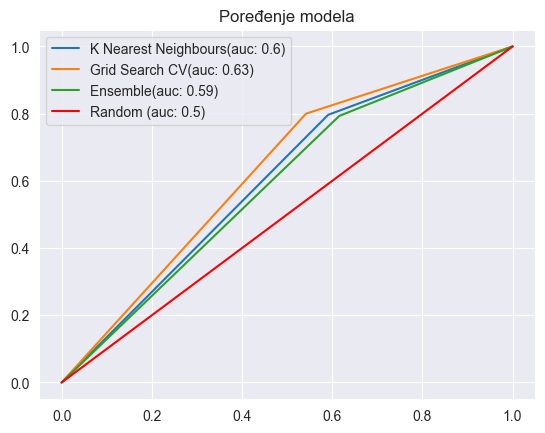

In [36]:
# Poredjenje
from helpers import print_roc_curve

models = {
    'K Nearest Neighbours': knn,
    'Grid Search CV': gscv,
    'Ensemble': baggingKnn,
}

print_roc_curve(models, X_test, y_test)

In [37]:
# Cuvamo najbolji model
from helpers import save_model

save_model(gscv, '../../models/knn_gscv.pkl')